# Effects of Support

Before we jump into evaluation, we take a tangent to figure out the effects of supports on our prediction

As a quick reminder, a support is like a piece of evidence that reinforces a hypothesis. With multiple supports, this hypothesis becomes more reliable.

We used support in our similarity algorithm between **2 players**, ensuring that they have **enough** common maps before judging their similarity. We coin it **Pair Support**
We also used it to predict an accuracy of a map, across **multiple players**. Giving us an idea on how many players is **enough** to predict a score well. We coin it **Similarity Support**

Thus, we study the effects of these 2 supports.
- Pair Support
- Similarity Support.

## Hypothesis

I hypothesize that the number of pair supports will affect evaluation accuracy.

This is because, if the number of pair supports is low, then the similarity fitting metric will not be reliable. i.e. if the number of points fitted (support) is low, the curve fit may not yield a representable metric.

To prove this, we will need to see a graph of **Pair Supports**, **Evaluation Residual**.
If the residual changes w.r.t. the supports, then it's true.

In [1]:
import warnings
from pathlib import Path

if True:
    # PyCharm linting keeps wrecking this import, so it's in a True cond
    from opal.score.similarity.similarity import similarity_pair, similarity_predict, PredCorrectionTransformer
from opal.score.dataset import Dataset
from opal.score.preprocessing_dynamic import PreprocessingDynamic

warnings.filterwarnings('ignore')

data_path = Path("../../data/osu/scores/")

df = PreprocessingDynamic(
    Dataset(data_path, "top1k").joined_filtered_df,
    unpopular_maps_thres=0.25,
    unpopular_plays_thres=0.25,
    sr_min_thres=2.5,
    acc_filter=(0.85, 1),
    score_filter=None
).filter(calc_acc=True)
df, df_sim, df_support, qt = similarity_pair(df, min_support=2)
pred = similarity_predict(df, df_sim, qt)
pct = PredCorrectionTransformer()
pred['predict_pct'] = pct.fit_transform(pred['accuracy'], pred['predict'])

by_score_year 887452 -> 541019
by_sr 541019 -> 481548
by_unpopular_maps 481548 -> 232472
by_unpopular_plays 232472 -> 50268
by_acc_filter 50268 -> 50202
by_remove_mod 50202 -> 47232
Users Left: 240 | Beatmaps Left: 506


100%|██████████| 283/283 [00:22<00:00, 12.52it/s]


Let's take a glance at the pair support matrix & similarity interaction matrix
The values indicate the number of supports per user & similarity respectively.

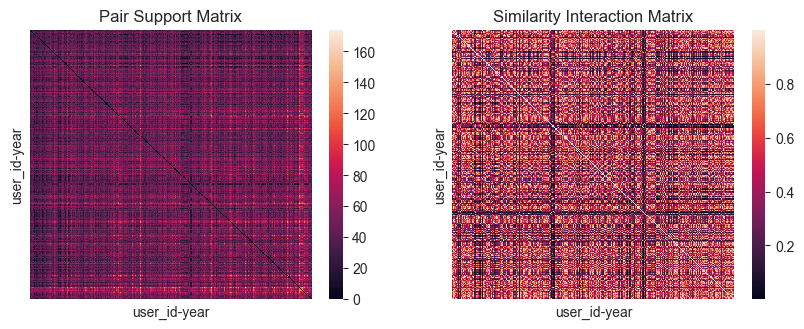

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
_ = sns.heatmap(df_support, yticklabels=False, xticklabels=False, ax=axs[0])
_ = axs[0].set_title("Pair Support Matrix")
_ = sns.heatmap(df_sim, yticklabels=False, xticklabels=False, ax=axs[1])
_ = axs[1].set_title("Similarity Interaction Matrix")

## Evaluating Pair Support

Is there any relationship between number of **Pair Supports** and evaluation accuracy?
If we removed similarities of low **Pair Supports**, will it increase accuracy?

To prove this, we put a threshold to the number of supports by boolean masking `df_support`.
`df_support` has the same shape as `df_sim`, where each cell represents the number of support used to generate the similarity matrix.

Importantly, we're interested to see at what range of supports, the prediction is subpar.
We then flag players with too little **Pair Supports** to be unsuitable for prediction.

My initial guess is that, if `df_support` is low enough, it'll create an unstable `df_sim` value.

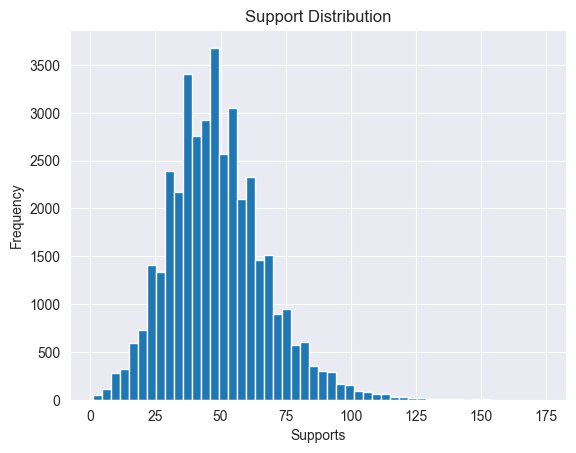

In [3]:
import numpy as np

supports = np.triu(df_support).flatten()
_ = plt.hist(supports[supports != 0], bins=50)
_ = plt.title("Support Distribution")
_ = plt.xlabel("Supports")
_ = plt.ylabel("Frequency")

Here, we see that many scores accrue high pair supports, peaking around 50 per player.

In [4]:
from sklearn.metrics import mean_squared_error

support_mse = {}
for thres in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    df_sim_thres = df_sim.copy(deep=True)
    df_sim_thres = df_sim_thres[df_support >= thres]
    pred = similarity_predict(df, df_sim_thres, qt)
    pct = PredCorrectionTransformer()
    x, y = pred['accuracy'], pred['predict']
    pred['predict_pct'] = pct.fit_transform(x, y)
    y_pct = pred['predict_pct']
    for support, g in pred.groupby('support'):
        support_mse[(thres, support)] = mean_squared_error(
            g['predict_pct'],
            g['accuracy'],
            squared=False
        )


100%|██████████| 283/283 [00:07<00:00, 35.88it/s]


After a long render, let's plot how accuracy changes with the threshold

In [5]:
import pandas as pd

df_support_mse = pd.DataFrame(
    support_mse.values(),
    index=support_mse.keys(),
    columns=['mse']
)
df_support_mse.index.names = ['pair_support', 'similarity_support']
df_support_mse_matrix = df_support_mse.unstack(level=-1).droplevel(0, axis=1)

## MSE w.r.t. Pair Support

We firstly take a look at how error changes with number of Pair Supports.

As a reminder, pair supports are the number of common maps between 2 players.
Thus, higher pair support indicates more maps with comparisons

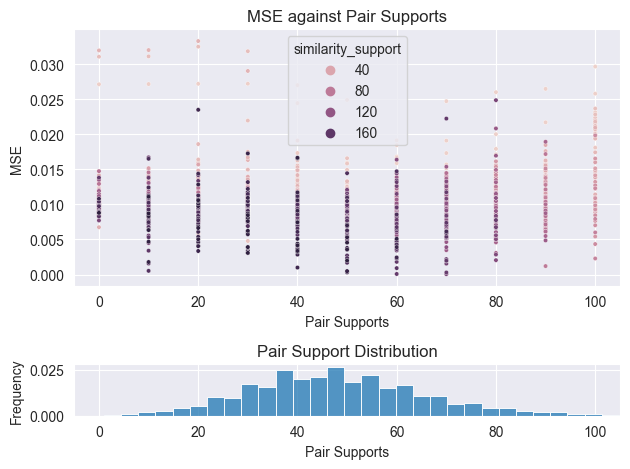

In [6]:
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 1]})
sns.scatterplot(
    x='pair_support',
    y='mse',
    data=df_support_mse.reset_index().astype(float),
    hue='similarity_support',
    s=10,
    ax=axs[0]
)
_ = axs[0].set_title("MSE against Pair Supports")
_ = axs[0].set_xlabel("Pair Supports")
_ = axs[0].set_xlim(-5, 105)
_ = axs[0].set_ylabel("MSE")
_ = sns.histplot(
    supports[supports != 0],
    bins=50,
    stat='density',
    ax=axs[1]
)
_ = axs[1].set_title("Pair Support Distribution")
_ = axs[1].set_xlabel("Pair Supports")
_ = axs[1].set_xlim(-5, 105)
_ = axs[1].set_ylabel("Frequency")
plt.tight_layout()

We see that there's not a strong correlation between number of pair supports and MSE.
However, it's clear that we should try to avoid excessively low and high pair supports.

There's also a plausible correlation between the distribution of pair supports and MSE.
Seems like more instances of `n` pair supports implies a lower error. However more evidence is needed to prove this causation.

## MSE w.r.t. Similarity Support

We'll plot the MSE against **similarity support**.

As a reminder, the **similarity support** is the number of players who have existing similarities to the current player.

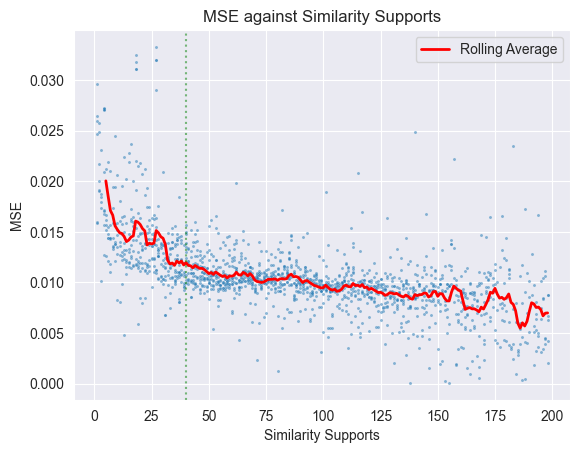

In [7]:
data = df_support_mse.reset_index().astype(float)
_ = sns.scatterplot(
    x='similarity_support',
    y='mse',
    data=data,
    s=5,
    alpha=0.5
)
_ = sns.lineplot(
    x='similarity_support',
    y='mse',
    data=data.groupby('similarity_support').mean().rolling(5).mean(),
    color='red',
    linewidth=2,
    label='Rolling Average'
)
_ = plt.legend()
_ = plt.axvline(40, alpha=0.5, color='green', linestyle='dotted')
_ = plt.title("MSE against Similarity Supports")
_ = plt.xlabel("Similarity Supports")
_ = plt.ylabel("MSE")

Here, we see a clear trend that the number of supports affect the MSE. Thus, we should aim for
supports as high as possible.

However, this brings us an important question:
If we limited the number of supports, how many players are we excluding?


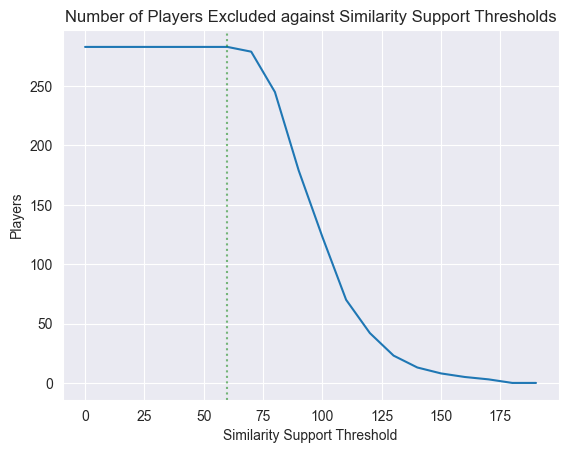

In [22]:
df_support_exc = []
x = []
for i in np.arange(0, 200, 10):
    df_support_exc.append((df_support > i).any(axis=1).sum())
    x.append(i)
_ = plt.plot(x, df_support_exc)
_ = plt.title("Number of Players Excluded against Similarity Support Thresholds")
_ = plt.xlabel("Similarity Support Threshold")
_ = plt.ylabel("Players")
_ = plt.axvline(60, alpha=0.5, color='green', linestyle='dotted')


Taking a look at this graph, we can see that our players starts being excluded at around 60+.

Drawing reference to our previous graph, it's decided that we should threshold around 50 for best performance!

## Summary

We've taken a look at our supports: **Pair Support** and **Similarity Support**, and deduced that:
- **Pair Support** does not have heavy impact on error, however it's best to chose supports > 10
- **Similarity Support** has a significant impact on error. The higher, the better, however it can cause players to be excluded from calculations. Thus, it's best to balance **error** and **number of players accepted**. We found this value to be around 50.